### Notebook 2

In [1]:
# Import necessary libraries for spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Used to access spotify api
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
# Bring in the usual suspects
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [4]:
# Import model from notebook 1
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()
# Set index
df.set_index('id', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5202 entries, 3AfajMb3XqqpE97TudO1ab to 7LDrkJUtbdijR0RKcJHwIu
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5202 non-null   float64
 1   energy            5202 non-null   float64
 2   key               5202 non-null   object 
 3   loudness          5202 non-null   float64
 4   mode              5202 non-null   object 
 5   speechiness       5202 non-null   float64
 6   acousticness      5202 non-null   float64
 7   instrumentalness  5202 non-null   float64
 8   liveness          5202 non-null   float64
 9   valence           5202 non-null   float64
 10  tempo             5202 non-null   float64
 11  duration_ms       5202 non-null   float64
 12  time_signature    5202 non-null   object 
 13  genre             5202 non-null   object 
dtypes: float64(10), object(4)
memory usage: 609.6+ KB


In [6]:
# The likelihood of a song having the same exact attributes of another song is extremely low 
# Bye bye duplicate songs
df.duplicated().sum()

94

In [7]:
# Drop in place and keep the first one
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
# Split the columns to easily use later
categorical_columns = list(df.drop('genre', axis = 1).select_dtypes('object').columns)
numerical_columns = list(df.drop('genre', axis = 1).select_dtypes(exclude = 'object').columns)

In [10]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                   random_state=9)

In [11]:
# See the percentage of each genre in the whole set
y_train.value_counts(normalize=True)

hip-hop      0.413469
alt-metal    0.251109
rock         0.195771
pop          0.139650
Name: genre, dtype: float64

In [12]:
# Function to easily view results
def evaluation_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical')

Gonna use f1-score as our metric to compare since the severity of us getting a false negative or a false positive isn't high, but just in general get a great idea of what each genre may be. 

**First Simple Model**

Give us a base model to compare future models to.

In [13]:
lr = LogisticRegression(random_state=9)
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train), y_train)

LogisticRegression(random_state=9)

In [14]:
lr.classes_

array(['alt-metal', 'hip-hop', 'pop', 'rock'], dtype=object)

Training
F1 Score: 0.6463455530359611


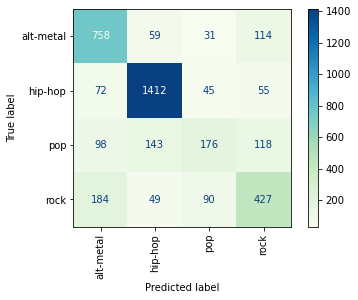

In [15]:
print('Training')
evaluation_report(lr, ss.fit_transform(X_train), y_train)

Testing
F1 Score: 0.6130564772151843


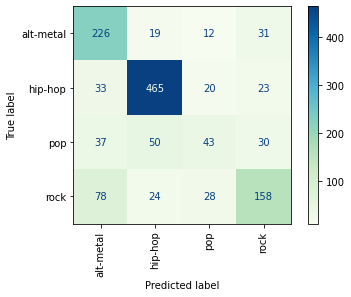

In [16]:
print('Testing')
evaluation_report(lr, ss.transform(X_test), y_test)

Training F1 Score: 0.6463455530359611
Testing F1 Score: 0.6130564772151843

For not addressing the scaling or the class imbalance.. that's pretty good.

<hl>

In [17]:
# Import imbalanced pipeline since you can't use SMOTE with the regular python pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV

Create pipelines for preprocessing. One for numerical data, one for categorical data and a column transformer to do both.

In [18]:
#Create pipelines
numerical_pipeline = imbpipeline(verbose=False,steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(verbose=False,steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False,))
                            ])

col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

col_ohe_solo = ColumnTransformer(verbose=False,transformers=[
    ('categorical', categorical_pipeline, categorical_columns)
])


<hl>

For the following models, I gridsearched the edge cases within the cells rather than creating new cells. 

**Second Model**

- Column transform categorical and numerical
- Address the class imbalance through a balanced class weight
- And lets grid search for best params

In [19]:
pipe_log = imbpipeline(verbose=False, steps=[
    ('col_trans', col_trans),
    ('lr', LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced'))
])

param_grid = [
    {
     'lr__penalty' : ['l1','l2'],
     'lr__C' : [.75,.5,.25],
     'lr__solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr = GridSearchCV(pipe_log, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.0s finished


GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                   

In [20]:
gs_lr.best_params_

{'lr__C': 0.25, 'lr__penalty': 'l2', 'lr__solver': 'saga'}

Training
F1 Score: 0.6590327574284212


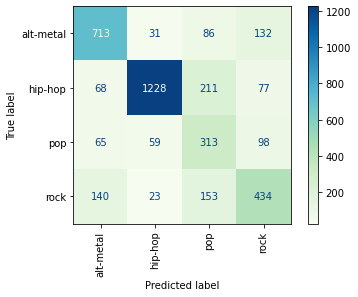

In [21]:
print('Training')
evaluation_report(gs_lr, X_train, y_train)

Testing
F1 Score: 0.6268594701576368


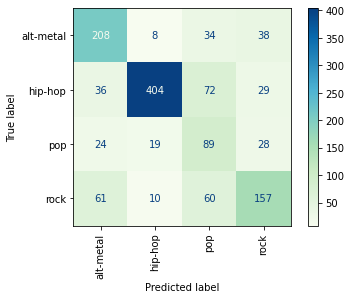

In [22]:
print('Testing')
evaluation_report(gs_lr, X_test, y_test)

Best params : {'lr__C': 0.25, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training F1 Score: 0.6590327574284212
Testing F1 Score: 0.6268594701576368

A higher score than our base model and continued low variance. Lets keep going

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
ohe = OneHotEncoder(drop='first', sparse=False)
sm = SMOTE(random_state = 9)


At this point, I realized something was going wrong when I used the pipelines so in turn, I decided to drop the pipeline and transform the data manually.

In [25]:
train_ohe = ohe.fit_transform(X_train[categorical_columns])
test_ohe = ohe.transform(X_test[categorical_columns])
train_ohe = X_train[numerical_columns].reset_index().join(pd.DataFrame(train_ohe)).set_index('id')

train_sm = sm.fit_resample(train_ohe, y_train)
test_ohe = X_test[numerical_columns].reset_index().join(pd.DataFrame(test_ohe)).set_index('id')

**Model 3**

Since we have a mixture of categorical and numerical features and a large amount of training samples, lets try XGBoost. Combine that with one hot encoder, smote, and gridsearch and let us see what happens. 

In [26]:
from xgboost import XGBClassifier

In [27]:
#Make sure not to over fit
xgbc = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree', 'dart']
}
#Run gridsearch
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='f1_macro', n_jobs =-1 )

In [28]:
gs_xgbc.fit(train_sm[0], train_sm[1])

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [29]:
gs_xgbc.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.789013182330305


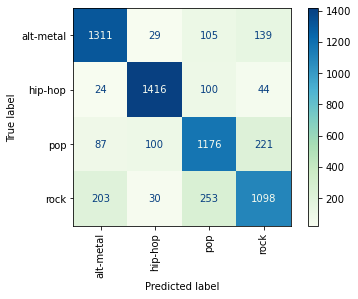

In [30]:
print('Training')
evaluation_report(gs_xgbc, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6770181424733226


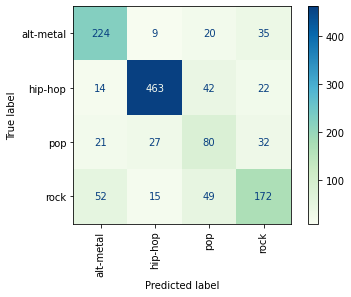

In [31]:
print('Testing')
evaluation_report(gs_xgbc, test_ohe, y_test)

Best Params: {'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}
 
 Training F1 Score: 0.789013182330305
 Testing F1 Score: 0.6770181424733226

High score, but high variance. Let's try to find a balance.

**Model 4**

Take a quick pivot and try gradient boosting classifier. 

In [32]:
gbclf = GradientBoostingClassifier(random_state = 9)

param_grid = [
    {
     'n_estimators' : [50,75,100,125],
     'learning_rate' : [.05, .1, .15, .2],
     'max_depth': [1,2]
    }, 
]

gs_gbclf = GridSearchCV(gbclf, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_gbclf.fit(train_sm[0], train_sm[1])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.3min finished


GridSearchCV(estimator=GradientBoostingClassifier(random_state=9), n_jobs=-1,
             param_grid=[{'learning_rate': [0.05, 0.1, 0.15, 0.2],
                          'max_depth': [1, 2],
                          'n_estimators': [50, 75, 100, 125]}],
             scoring='f1_macro', verbose=True)

In [33]:
gs_gbclf.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 125}

Training
F1 Score: 0.827129002007025


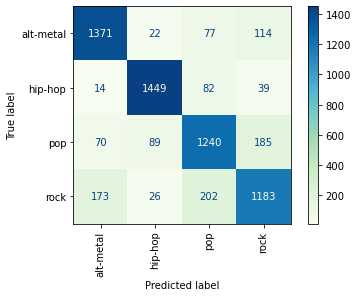

In [34]:
print('Training')
evaluation_report(gs_gbclf, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6771860937513159


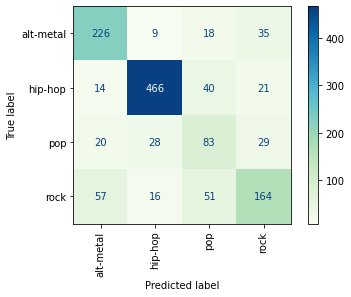

In [35]:
print('Testing')
evaluation_report(gs_gbclf, test_ohe, y_test)

Best Params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 125}
Training F1 Score: 0.827129002007025
Testing F1 Score: 0.6771860937513159

Again high score but high variance. It's not the best best yet. 

**Model 5**

Here I wanted to try the logistic regression without the pipeline just to do a quick logic check as well as see if it made a difference. 

In [36]:
lr_col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

lr_train_transf = lr_col_trans.fit_transform(X_train)
lr_test_transf = lr_col_trans.transform(X_test)

In [37]:
lr2 = LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced')

param_grid = [
    {
     'penalty' : ['l1','l2'],
     'C' : [.75,.5,.25],
     'solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr2 = GridSearchCV(lr2, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr2.fit(lr_train_transf, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.5s finished


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=9),
             n_jobs=-1,
             param_grid=[{'C': [0.75, 0.5, 0.25], 'penalty': ['l1', 'l2'],
                          'solver': ['saga', 'sag', 'lbfgs']}],
             scoring='f1_macro', verbose=True)

In [38]:
gs_lr2.best_params_

{'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}

Training
F1 Score: 0.6590327574284212


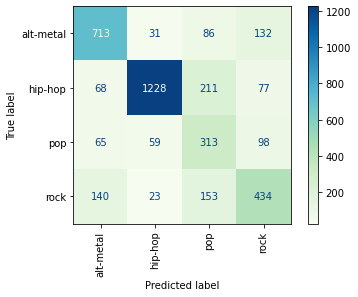

In [39]:
print('Training')
evaluation_report(gs_lr2, lr_train_transf, y_train)

Testing
F1 Score: 0.6268594701576368


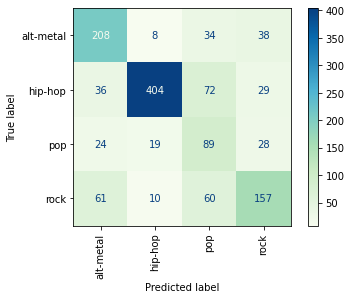

In [40]:
print('Testing')
evaluation_report(gs_lr2, lr_test_transf, y_test)

No difference, same scores as the inital logistic regression

**Model 6**

Try XGBoost with an added class_weight attribute to account for the class imbalance. 

In [41]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [42]:
classes_weights

array([1.79018692, 0.99558212, 0.99558212, ..., 1.79018692, 0.60464015,
       0.60464015])

In [43]:
xgbc2 = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree','dart'],
#     'weight': classes_weights
}
#Run gridsearch
gs_xgbc2 = GridSearchCV(xgbc2, param_grid=params, scoring='f1_macro', n_jobs =-1 )
gs_xgbc2.fit(train_ohe, y_train, sample_weight=classes_weights)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [44]:
gs_xgbc2.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 180}

Training
F1 Score: 0.7403661524883499


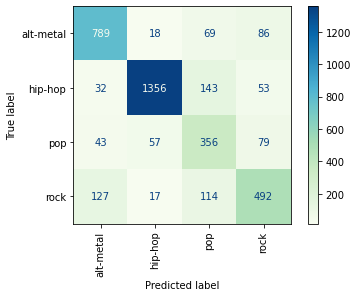

In [45]:
print('Training')
evaluation_report(gs_xgbc2, train_ohe, y_train)

Testing
F1 Score: 0.6664085968708471


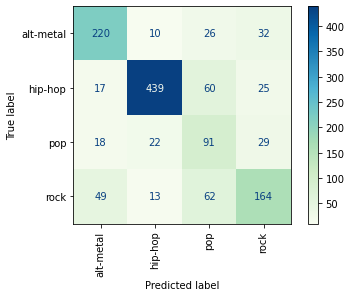

In [46]:
print('Testing')
evaluation_report(gs_xgbc2, test_ohe, y_test)

Best Params: 
{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 180}

Training
F1 Score: 0.7403661524883499

Testing
F1 Score: 0.6664085968708471

### Pick the best model 

In [47]:
best_model = gs_xgbc2.best_estimator_

In [48]:
X_final = df.drop('genre', axis = 1)
y_final = df.genre

In [49]:
# Follow the same transformation on the initial model and do the same to whole dataframe
final_ohe = ohe.transform(X_final[categorical_columns])
final_ohe = X_final[numerical_columns].reset_index().join(pd.DataFrame(final_ohe)).set_index('id')

In [50]:
final_ohe

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,5,6,7,8,9,10,11,12,13,14
id,,,,,,,,,,,,,,,,,,,,,
3AfajMb3XqqpE97TudO1ab,0.253,0.888,-4.592,0.0787,0.000225,0.013200,0.9960,0.195,105.763,373800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4voEoczU7Ijborps9XF1n3,0.846,0.416,-13.767,0.1180,0.156000,0.000009,0.2380,0.645,96.188,259000.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3iD2CCv5bsJRIaqJRYD0uJ,0.381,0.162,-12.440,0.0295,0.880000,0.000000,0.0882,0.345,96.744,125533.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7rRLVR3QZOGPkNckz4DSAc,0.521,0.881,-5.417,0.0850,0.000922,0.035100,0.0976,0.377,150.151,250107.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
23SDAWj9QEg7KEB77MMFPf,0.844,0.809,-7.320,0.0476,0.002020,0.759000,0.0984,0.753,108.343,212467.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1hSXWecpKNqhAkxZ5FMBe9,0.453,0.947,-5.292,0.0731,0.000214,0.000464,0.4900,0.265,117.963,172307.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6LtfQ7JJkkDw2t9hxJOwnf,0.556,0.849,-6.465,0.0417,0.004530,0.000016,0.2720,0.290,105.016,236093.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0eK5y1c7WDyWwx6k9SFjbT,0.561,0.774,-3.144,0.4470,0.399000,0.000002,0.1890,0.820,77.621,337760.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Fit the best model on whole dataset

In [51]:
#Fit best model on whole dataset
best_model.fit(final_ohe, y_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=9, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

F1 Score: 0.7350702078615245


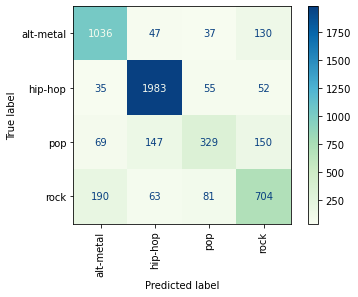

In [53]:
# See how well it does
evaluation_report(best_model, final_ohe, y_final)

Pretty high score for the test score for the set it trained on 

#### See which features are most important in predicting genre

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

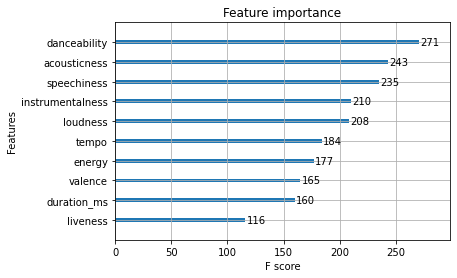

In [54]:
from xgboost import plot_importance
plot_importance(best_model, max_num_features=10)

Add unsurprisingly, the features that had clear differences in the EDA are the features that have the most importance. We won't be able to tell the gravitas of each feature or which feature predicts which genre more but cool to see. No surprises.  

In [55]:
all_songs = df

#### Modify the dataset with the results

Add the predicted genre as the genre for each song to use in our content based recommender system and drop the intial genre column pulled by the playlist. 

In [56]:
all_songs['predicted_genre'] = best_model.predict(final_ohe)
all_songs.drop(['genre'], axis = 1, inplace = True)

#### Export the model

In [57]:
#Export the best model to be used in the other notebooks.
pickle_out = open('pickled_files/all_songs_genre_predicted.pickle',"wb")
pickle.dump([all_songs, best_model, ohe], pickle_out)
pickle_out.close()

In [58]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
3AfajMb3XqqpE97TudO1ab,0.253,0.888,4,-4.592,0,0.0787,0.000225,0.013200,0.9960,0.195,105.763,373800.0,4,alt-metal
4voEoczU7Ijborps9XF1n3,0.846,0.416,10,-13.767,0,0.1180,0.156000,0.000009,0.2380,0.645,96.188,259000.0,4,hip-hop
3iD2CCv5bsJRIaqJRYD0uJ,0.381,0.162,5,-12.440,1,0.0295,0.880000,0.000000,0.0882,0.345,96.744,125533.0,4,rock
7rRLVR3QZOGPkNckz4DSAc,0.521,0.881,10,-5.417,0,0.0850,0.000922,0.035100,0.0976,0.377,150.151,250107.0,3,alt-metal
23SDAWj9QEg7KEB77MMFPf,0.844,0.809,2,-7.320,1,0.0476,0.002020,0.759000,0.0984,0.753,108.343,212467.0,4,hip-hop
